### Exploratory Data Analysis on CT Scans

In [1]:
## import necessary libraries

import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pydicom import dcmread

import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline

#### Create a dataframe that will aid in analyzing the dataset

In [2]:
## Patient ID, Scan ID, Image Addr, Labels Addr, Image Size, Image Height, Image Width, Label File, Organ_1, Organ_2, Organ_3, Organ_4
dataset_info = []

IMAGE_FOLDER = 'coding_test_files/dicom_series/'
SEG_FOLDER ='coding_test_files/segmentation_data/'
patients = os.listdir(IMAGE_FOLDER)
patients.sort()

for i in patients:
    for j in os.listdir(IMAGE_FOLDER + i):
        image_addr = IMAGE_FOLDER + i + '/' + j 
        image_file = dcmread(image_addr).pixel_array
        
        ## check the segmentation file
        last_slash = image_addr.find('dicom_series/') + 13
        sample = image_addr[last_slash:-4]
        label_addr = SEG_FOLDER + sample +'.npz'

        if os.path.isfile(label_addr):
            label_file = np.load(label_addr)['arr_0']
            organ_1 = 1 if np.sum(label_file[:,:,0]) > 0 else 0
            organ_2 = 1 if np.sum(label_file[:,:,1]) > 0 else 0
            organ_3 = 1 if np.sum(label_file[:,:,2]) > 0 else 0
            organ_4 = 1 if np.sum(label_file[:,:,3]) > 0 else 0
            label = 1
        else:
            organ_1, organ_2, organ_3, organ_4, label, label_file = 0, 0, 0, 0, 0, None
            label_addr = None


        dataset_info.append({
            'patientID': i,
            'scanID': j[:-4],
            'image_addr': image_addr,
            'label_addr': label_addr,
            #'image': image_file,  ## takes memory
            'image_size': image_file.shape,
            'image_height': image_file.shape[0],
            'image_width': image_file.shape[1],
            
            'label': label,
            #'label_file': label_file,  ## takes memory
            'organ_1': organ_1,
            'organ_2': organ_2,
            'organ_3': organ_3,
            'organ_4': organ_4
        })

In [3]:
## convert the info into a dataframe and display first 10

dataset_df = pd.DataFrame(dataset_info)
dataset_df.head(10)

,patientID,scanID,image_addr,label_addr,image_size,image_height,image_width,label,organ_1,organ_2,organ_3,organ_4
0,1201,100,coding_test_files/dicom_series/1201/100.dcm,coding_test_files/segmentation_data/1201/100.npz,"(512, 512)",512,512,1,0,0,0,1
1,1201,101,coding_test_files/dicom_series/1201/101.dcm,coding_test_files/segmentation_data/1201/101.npz,"(512, 512)",512,512,1,0,0,0,1
2,1201,102,coding_test_files/dicom_series/1201/102.dcm,coding_test_files/segmentation_data/1201/102.npz,"(512, 512)",512,512,1,0,0,0,1
3,1201,103,coding_test_files/dicom_series/1201/103.dcm,coding_test_files/segmentation_data/1201/103.npz,"(512, 512)",512,512,1,0,0,0,1
4,1201,104,coding_test_files/dicom_series/1201/104.dcm,coding_test_files/segmentation_data/1201/104.npz,"(512, 512)",512,512,1,0,0,0,1
5,1201,105,coding_test_files/dicom_series/1201/105.dcm,coding_test_files/segmentation_data/1201/105.npz,"(512, 512)",512,512,1,0,0,0,1
6,1201,106,coding_test_files/dicom_series/1201/106.dcm,coding_test_files/segmentation_data/1201/106.npz,"(512, 512)",512,512,1,0,0,0,1
7,1201,107,coding_test_files/dicom_series/1201/107.dcm,coding_test_files/segmentation_data/1201/107.npz,"(512, 512)",512,512,1,0,0,0,1
8,1201,108,coding_test_files/dicom_series/1201/108.dcm,coding_test_files/segmentation_data/1201/108.npz,"(512, 512)",512,512,1,0,0,0,1
9,1201,109,coding_test_files/dicom_series/1201/109.dcm,coding_test_files/segmentation_data/1201/109.npz,"(512, 512)",512,512,1,0,0,0,1


#### Check the dataset distribution

In [4]:
## number of total images and labels
print('images no:', dataset_df['image_addr'].count(), '\nlabels no:', dataset_df['label_addr'].count())

images no: 4403 
labels no: 3772


In [5]:
## number of images per patient
dataset_df.groupby('patientID').size()

patientID
1201    252
137     718
397      64
4123    175
4622    192
4759    861
4890    835
525     203
527     352
778     751
dtype: int64

In [6]:
## number of labels per patient
dataset_df.groupby('patientID')['label'].sum()

patientID
1201    190
137     635
397      64
4123    164
4622    155
4759    684
4890    726
525     182
527     299
778     673
Name: label, dtype: int64

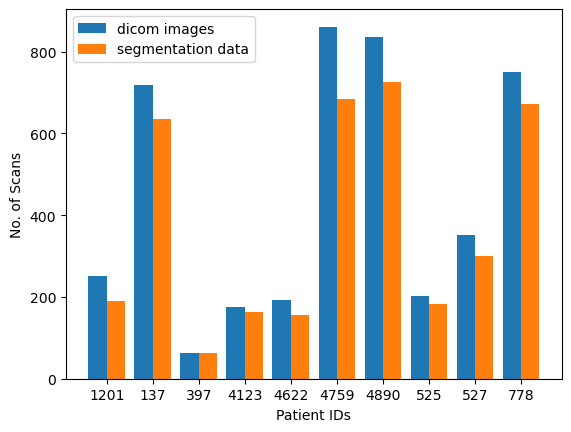

In [7]:
## plot the number of image files (dicom) and label files distribution

no_of_imgs = list(dataset_df.groupby('patientID').size())
no_of_lbls = list(dataset_df.groupby('patientID')['label'].sum())

names = patients
value = no_of_imgs

X_axis = np.arange(len(names)) 
plt.xticks(X_axis, names)

plt.xlabel('Patient IDs')
plt.ylabel('No. of Scans')
plt.bar(X_axis -.2, value, .4, label='dicom images')

## segmentation distribution
value_seg = no_of_lbls
plt.bar(X_axis+.2, value_seg, .4, label='segmentation data')

plt.legend()
plt.show()

In [8]:
## Check the sum of labels per organ

dataset_df[['organ_1', 'organ_2', 'organ_3', 'organ_4']].sum()

organ_1    1476
organ_2     847
organ_3     915
organ_4    3772
dtype: int64

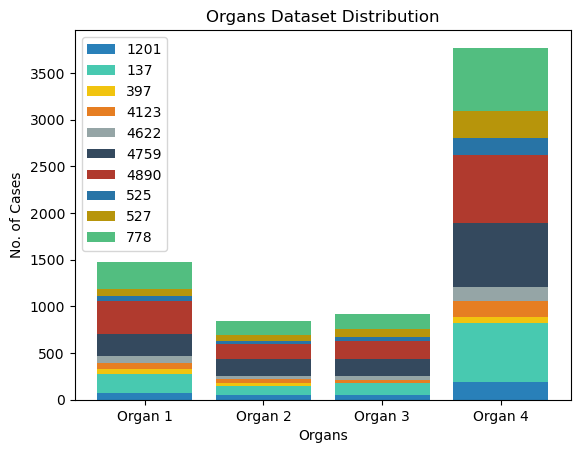

In [9]:
## plot the labels distribution per patient ID

## process dataframe

organ_1_val = list(dataset_df.groupby('patientID')['organ_1'].sum())
organ_2_val = list(dataset_df.groupby('patientID')['organ_2'].sum())
organ_3_val = list(dataset_df.groupby('patientID')['organ_3'].sum())
organ_4_val = list(dataset_df.groupby('patientID')['organ_4'].sum())

organ_dict = {}
for i in range(len(patients)):
    organ_dict[patients[i]] = [organ_1_val[i], organ_2_val[i], organ_3_val[i], organ_4_val[i]]

## plot

# create data
x = ['Organ 1', 'Organ 2', 'Organ 3', 'Organ 4']
y1 = np.array(organ_dict[patients[0]])
y2 = np.array(organ_dict[patients[1]])
y3 = np.array(organ_dict[patients[2]])
y4 = np.array(organ_dict[patients[3]])
y5 = np.array(organ_dict[patients[4]])
y6 = np.array(organ_dict[patients[5]])
y7 = np.array(organ_dict[patients[6]])
y8 = np.array(organ_dict[patients[7]])
y9 = np.array(organ_dict[patients[8]])
y10 = np.array(organ_dict[patients[9]])

# plot bars in stack manner
plt.bar(x, y1, color='#2980B9')
plt.bar(x, y2, bottom=y1, color='#48C9B0')
plt.bar(x, y3, bottom=y1+y2, color='#F1C40F')
plt.bar(x, y4, bottom=y1+y2+y3, color='#E67E22')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color='#95A5A6')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, color='#34495E')
plt.bar(x, y7, bottom=y1+y2+y3+y4+y5+y6, color='#B03A2E')
plt.bar(x, y8, bottom=y1+y2+y3+y4+y5+y6+y7, color='#2874A6')
plt.bar(x, y9, bottom=y1+y2+y3+y4+y5+y6+y7+y8, color='#B7950B')
plt.bar(x, y10, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9, color='#52BE80')
plt.xlabel("Organs")
plt.ylabel("No. of Cases")
plt.legend(list(patients))
plt.title("Organs Dataset Distribution")
plt.show()

#### Check further dataset information (e.g., file info)

In [10]:
## other information

dataset_df.describe()

,image_height,image_width,label,organ_1,organ_2,organ_3,organ_4
count,4403.0,4403.0,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000
mean,512.0,512.0,0.856689,0.335226,0.192369,0.207813,0.856689
std,0.0,0.0,0.350430,0.472123,0.394206,0.405788,0.350430
min,512.0,512.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,512.0,512.0,1.000000,0.000000,0.000000,0.000000,1.000000
50%,512.0,512.0,1.000000,0.000000,0.000000,0.000000,1.000000
75%,512.0,512.0,1.000000,1.000000,0.000000,0.000000,1.000000
max,512.0,512.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
## view info of a specific patient and slice
patientID = '4759'
scanID = '858'

((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df['scanID'] == scanID])

,patientID,scanID,image_addr,label_addr,image_size,image_height,image_width,label,organ_1,organ_2,organ_3,organ_4
2243,4759,858,coding_test_files/dicom_series/4759/858.dcm,None,"(512, 512)",512,512,0,0,0,0,0


### Visualize the slices and the masked area

In [12]:
## Combines image and its segmentation mask into a single image.

def extract_segmented_part(
    image: np.ndarray,
    mask: np.ndarray,
    fill_value: int = None,
    inverted: bool = False
) -> np.ndarray:
    
    if inverted:
        mask = np.logical_not(mask)
    
    if fill_value == None:
        fill_value = np.min(image)
    masked = np.ma.MaskedArray(image, mask=mask, fill_value=fill_value)
    image_overlay = masked.filled()
    
    return image_overlay

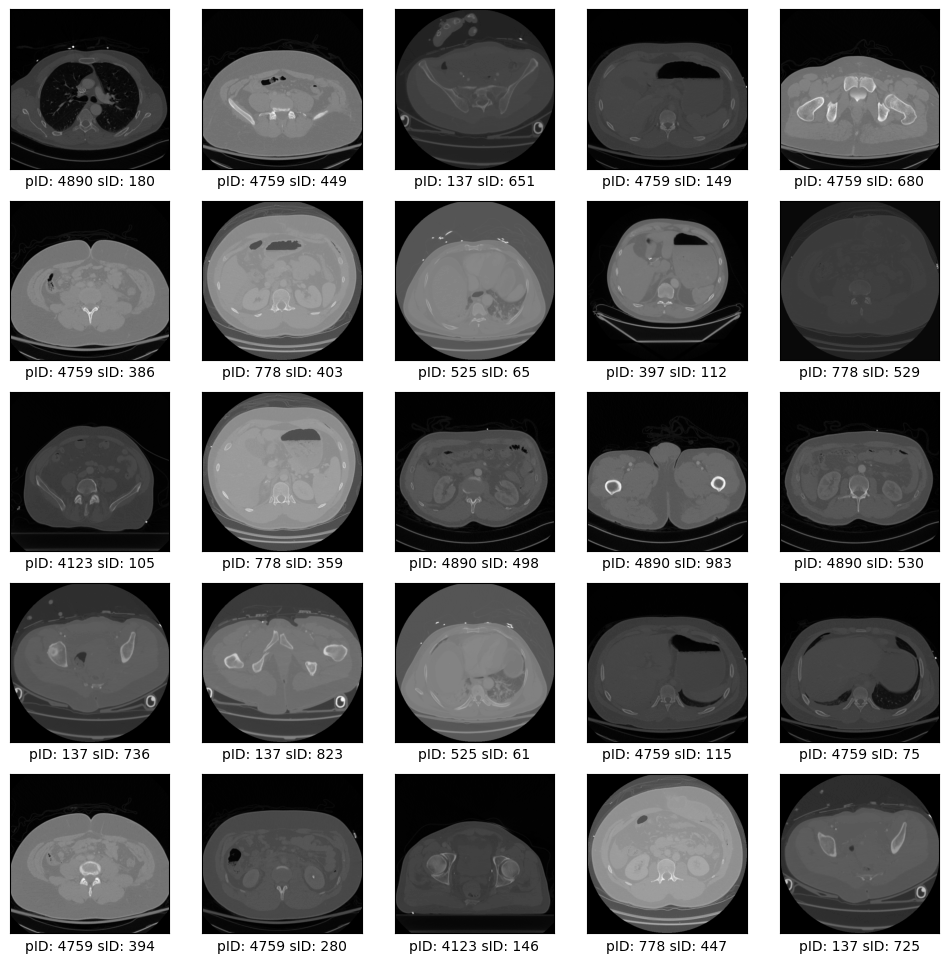

In [13]:
## Sample from dataframe and view slices

SEED = 20
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
images_to_sample =dataset_df.sample(n=25, random_state=SEED)
images_to_sample.reset_index(inplace=True)
for i, axis in enumerate(ax.flat):
    image = dcmread(images_to_sample.iloc[[i]]['image_addr'].item()).pixel_array
    axis.imshow(image, cmap='gray')
    plot_ID = "pID: " + images_to_sample.iloc[[i]]['patientID'].item() + " sID: " + images_to_sample.iloc[[i]]['scanID'].item() 
    axis.set(xticks=[], yticks=[], xlabel=plot_ID)
    axis.xaxis.get_label().set_fontsize(10)

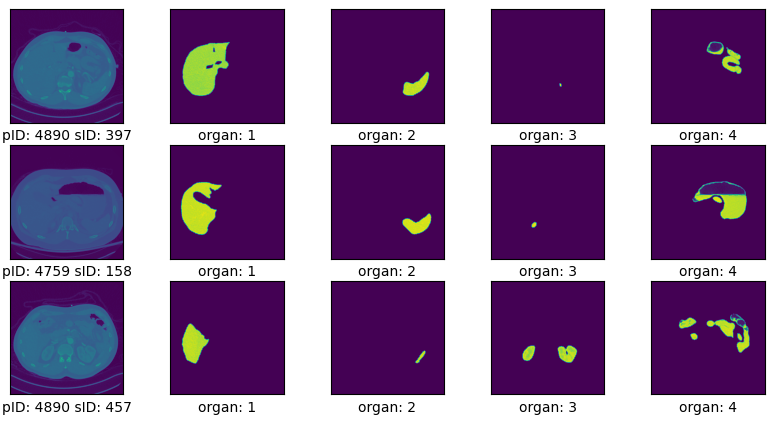

In [14]:
## View images and its masked area

SEED = 10
n_samples = 3
fig, ax = plt.subplots(n_samples, 5, figsize=(10, 5))
## select from images with labels on most organs
d = ((dataset_df.loc[dataset_df['organ_1'] == 1]).loc[dataset_df['organ_2'] == 1]).loc[dataset_df['organ_3'] == 1]
images_to_sample = d.sample(n=n_samples, random_state=SEED)
images_to_sample.reset_index(inplace=True)

axis = [i for i in ax.flat]
index = 0
for i in range(n_samples):
    image = dcmread(images_to_sample.iloc[[i]]['image_addr'].item()).pixel_array
    axis[index].imshow(image)   
    plot_ID = "pID: " + images_to_sample.iloc[[i]]['patientID'].item() + " sID: " + images_to_sample.iloc[[i]]['scanID'].item() 
    axis[index].set(xticks=[], yticks=[], xlabel=plot_ID)
    axis[index].xaxis.get_label().set_fontsize(10)
    index = index +1

    ## mask organs
    for j in range(4):
        mask = np.load(images_to_sample.iloc[[i]]['label_addr'].item())['arr_0'][:,:,j]
        masked = extract_segmented_part(image, mask, inverted=True, fill_value=0)
        axis[index].imshow(masked)   
        plot_ID = "organ: " + str(j+1)
        axis[index].set(xticks=[], yticks=[], xlabel=plot_ID)
        axis[index].xaxis.get_label().set_fontsize(10)
        index = index + 1 



### View the organs in 3D to estimate its type

In [15]:
# Load the necessary functions

## loads the scans per patient and replaces the masked area with -5000 to separate the organ
def load_scan_with_filter(img_path, lbl_path, organ_no):

    slices, images = [], []
    for i, l in zip(img_path, lbl_path):
        img_temp = dcmread(i)
        mask = np.load(l)['arr_0'][:,:,(organ_no-1)]
        masked = extract_segmented_part(img_temp.pixel_array, mask, fill_value=-5000) ## separates the organ with a value outside hu

        slices.append(img_temp)
        images.append(masked)

    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices, images

## converts the value into HU (Hounsfield Unit) and cleans out of bounds pixels
def get_pixels_hu(slices, images):
    image = np.stack([s for s in images])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:

            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

## redistributes the spacing between samples
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

## combines slices into a 3D image with focus on the threshold (e.g., -500 for lungs or -5000 for masked area)
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

C:\Users\JanouxRX\AppData\Local\Temp\ipykernel_17344\2174226959.py:63: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


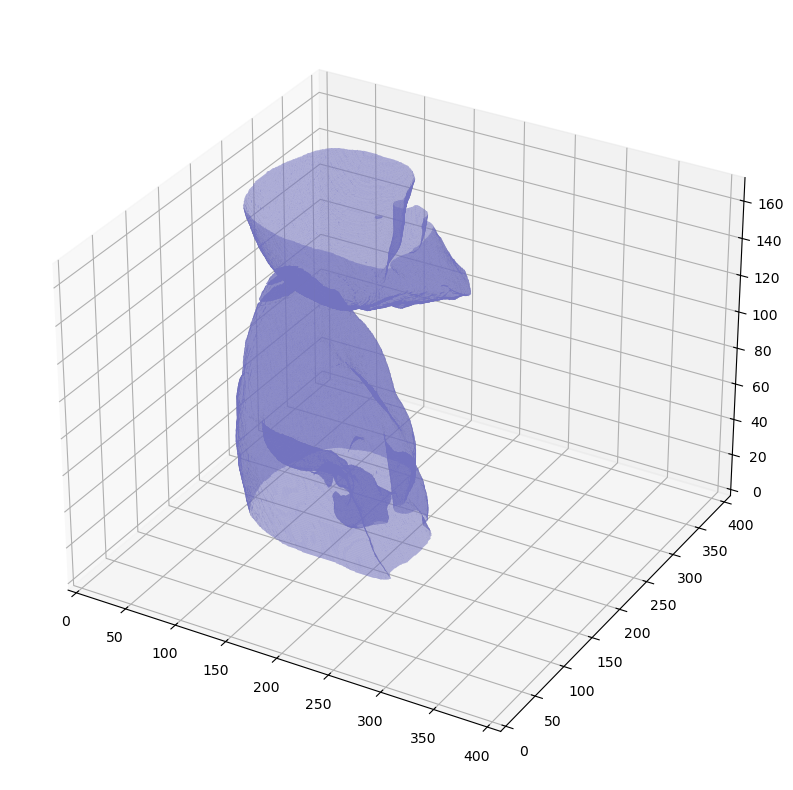

In [16]:
## get list of the organ image and label addresses
organ_name = 'organ_1'  ## choose organ number
patientID = '4759' ## choose patient name

organ_number = int(organ_name[-1])
organ_img_addr = list(((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df[organ_name] == 1])['image_addr'])
organ_lbl_addr = list(((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df[organ_name] == 1])['label_addr'])


## process the images from the list generated
patient_scan, images = load_scan_with_filter(organ_img_addr, organ_lbl_addr, organ_number)
patient_scan_pixels = get_pixels_hu(patient_scan, images)
pix_resampled, spacing = resample(patient_scan_pixels, patient_scan, [1,1,1])

## Organ 1 PatientID: 4759 Guess: Lungs Correct: Liver
plot_3d(pix_resampled, -5000)

C:\Users\JanouxRX\AppData\Local\Temp\ipykernel_17344\2174226959.py:63: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


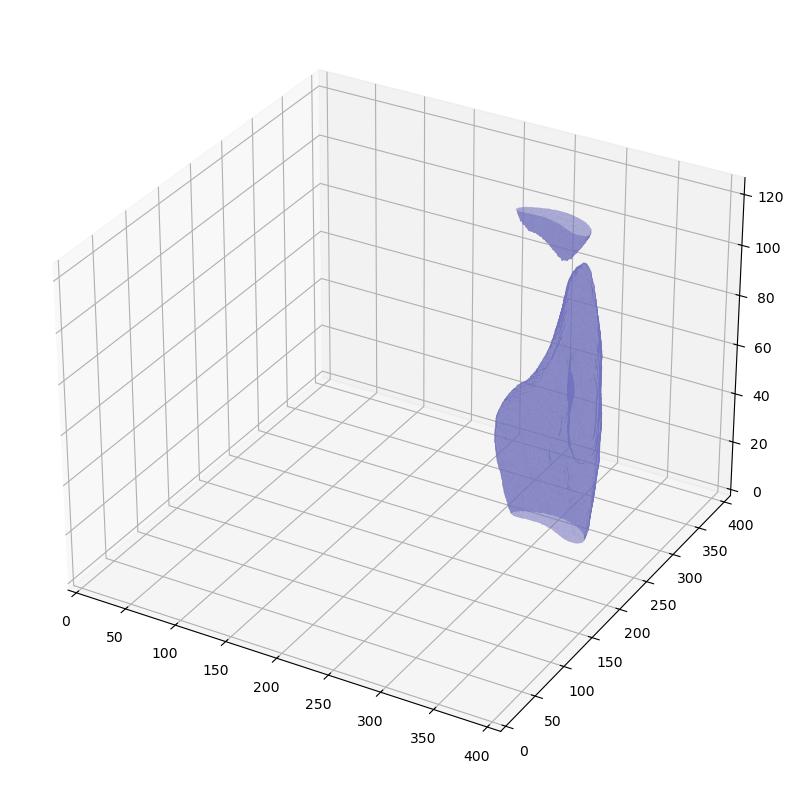

In [17]:
## get list of the organ image and label addresses
organ_name = 'organ_2'  ## choose organ number
patientID = '4759' ## choose patient name

organ_number = int(organ_name[-1])
organ_img_addr = list(((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df[organ_name] == 1])['image_addr'])
organ_lbl_addr = list(((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df[organ_name] == 1])['label_addr'])


## process the images from the list generated
patient_scan, images = load_scan_with_filter(organ_img_addr, organ_lbl_addr, organ_number)
patient_scan_pixels = get_pixels_hu(patient_scan, images)
pix_resampled, spacing = resample(patient_scan_pixels, patient_scan, [1,1,1])

## Organ 2 PatientID: 4759 Guess: Liver Correct: Spleen
plot_3d(pix_resampled, -5000)

C:\Users\JanouxRX\AppData\Local\Temp\ipykernel_17344\2174226959.py:63: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


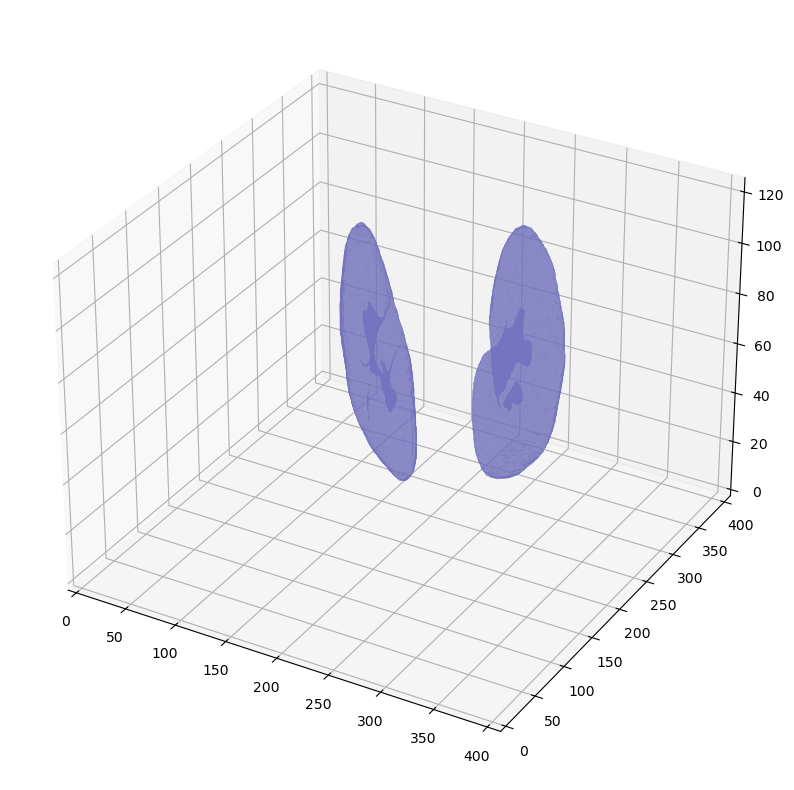

In [18]:
## get list of the organ image and label addresses
organ_name = 'organ_3'  ## choose organ number
patientID = '4759' ## choose patient name

organ_number = int(organ_name[-1])
organ_img_addr = list(((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df[organ_name] == 1])['image_addr'])
organ_lbl_addr = list(((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df[organ_name] == 1])['label_addr'])


## process the images from the list generated
patient_scan, images = load_scan_with_filter(organ_img_addr, organ_lbl_addr, organ_number)
patient_scan_pixels = get_pixels_hu(patient_scan, images)
pix_resampled, spacing = resample(patient_scan_pixels, patient_scan, [1,1,1])

## Organ 3 PatientID: 4759 Guess: Kidney
plot_3d(pix_resampled, -5000)

C:\Users\JanouxRX\AppData\Local\Temp\ipykernel_17344\2174226959.py:63: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


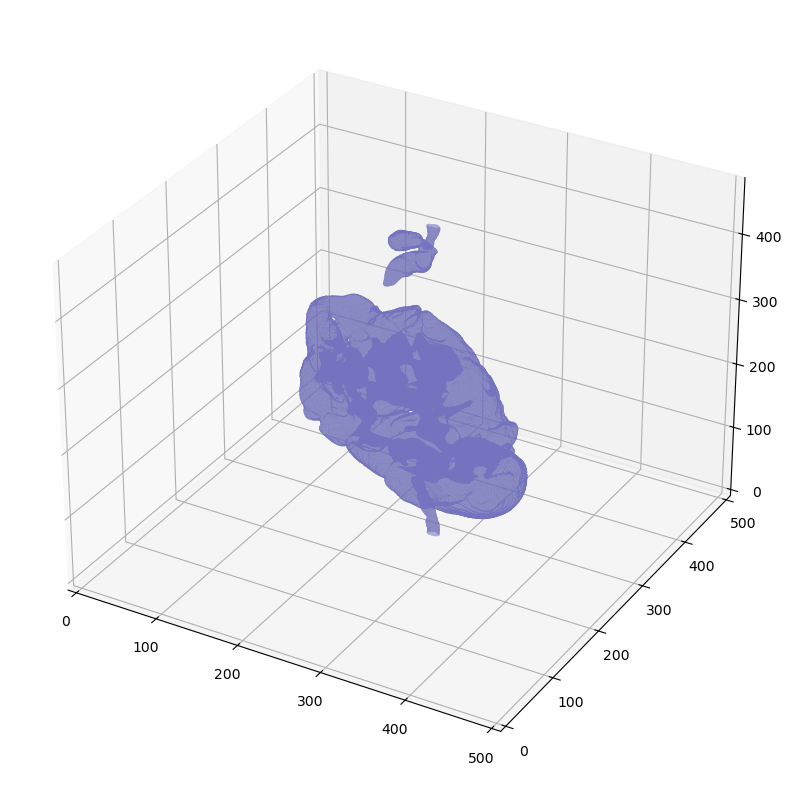

In [19]:
## get list of the organ image and label addresses
organ_name = 'organ_4'  ## choose organ number
patientID = '1201' ## choose patient name

organ_number = int(organ_name[-1])
organ_img_addr = list(((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df[organ_name] == 1])['image_addr'])
organ_lbl_addr = list(((dataset_df.loc[dataset_df['patientID'] == patientID]).loc[dataset_df[organ_name] == 1])['label_addr'])


## process the images from the list generated
patient_scan, images = load_scan_with_filter(organ_img_addr, organ_lbl_addr, organ_number)
patient_scan_pixels = get_pixels_hu(patient_scan, images)
pix_resampled, spacing = resample(patient_scan_pixels, patient_scan, [1,1,1])

## Organ 4 PatientID: 1201 Guess: Pancreas Correct: Intestine
plot_3d(pix_resampled, -5000)